# Bloch-Torrey Equation

## Introduction

Here we solve the Bloch-Torrey equation on a unit square, with the diffusion coefficient $D(x)$, relaxation rates $R_1(x)$ and $R_2(x)$, and resonance frequency $\omega(x)$ all given as a generic functions.
The strong form of the Bloch-Torrey equation is given by

\begin{align}
\begin{cases}
    \frac{\partial M_x}{\partial t} &= \nabla \cdot (D \cdot \nabla M_x) - R_2 \, M_x + \omega \, M_y\\
    \frac{\partial M_y}{\partial t} &= \nabla \cdot (D \cdot \nabla M_y) - R_2 \, M_y - \omega \, M_x\\
    \frac{\partial M_z}{\partial t} &= \nabla \cdot (D \cdot \nabla M_z) - R_1 \, (M_z - M_{z,\infty}),
\end{cases}\label{eq:strong_M}\tag{0}
\end{align}

where $\vec{M}(x,t) = [M_x(x,t), \, M_y(x,t), \, M_z(x,t)]$ is the magnetization vector.

Letting $\vec{u}(x,t) = [M_x(x,t), \, M_y(x,t), \, M_{z,\infty} - M_z(x,t)]$, equation (\ref{eq:strong_M}) becomes

\begin{align}
\begin{cases}
    \frac{\partial u_x}{\partial t} &= \nabla \cdot (D \cdot \nabla u_x) - R_2 \, u_x + \omega \, u_y\\
    \frac{\partial u_y}{\partial t} &= \nabla \cdot (D \cdot \nabla u_y) - R_2 \, u_y - \omega \, u_x\\
    \frac{\partial u_z}{\partial t} &= \nabla \cdot (D \cdot \nabla u_z) - R_1 \, u_z,
\end{cases}\label{eq:strong}\tag{1}
\end{align}

Equation (\ref{eq:strong}) holds for all points $x$ in the domain $\Omega$.

Note: $\cdot$ is generally a tensor contraction, unless the arguments are scalar, in which it reduces to multiplication.

We consider homogeneous Neumann boundary conditions such that

\begin{align}
    D \, \nabla \vec{u}(x) \cdot \hat{n} &= \vec{0}  \quad \forall x \in \partial \Omega\label{eq:bc}\tag{2}\\
\end{align}

where $\partial \Omega$ denotes the boundary of $\Omega$. The initial condition is assumed to be specified,

\begin{equation}
    \vec{u}(x,t=0) = \vec{u}_0 (x)  \quad \forall x \in \Omega.\label{eq:ic}\tag{3}
\end{equation}

The weak form corresponding to equation \ref{eq:strong} is given by

\begin{align}
    \int_{\Omega} \vec{v} \cdot \vec{u}_t \, d\Omega
    &= -\int_{\Omega}
    -\vec{v} \cdot \nabla \cdot ( D \, \nabla \vec{u} ) +
    \vec{v} \cdot (\vec{R} \odot \vec{u}) -
    \omega \, \vec{v}_\perp \times \vec{u}_\perp
    \, d\Omega \\
    &= -\int_{\Omega}
    \nabla \vec{v} : D \, \nabla \vec{u} +
    \vec{v} \cdot (\vec{R} \odot \vec{u}) -
    \omega \, \vec{v}_\perp \times \vec{u}_\perp
    \, d\Omega + 
    \int_{\partial\Omega} \vec{v} \cdot (D \, \nabla\vec{u} \cdot \hat{n}) \, d\Gamma,
\end{align}

where $\vec{v}$ is a suitable test function, $\vec{R} = [R_2, R_2, R_1]$, $\odot$ is the Hadamard (elementwise) product, and $\vec{u}_\perp$ is the transverse component $[u_x, u_y]$ of $\vec{u}$.

Applying the homogeneous Neumann boundary conditions from equation (\ref{eq:bc}), the final weak form becomes
\begin{align}
    \int_{\Omega} \vec{v} \cdot \vec{u}_t \, d\Omega
    = -\int_{\Omega}
    \nabla \vec{v} : D \, \nabla \vec{u} +
    \vec{v} \cdot (\vec{R} \odot \vec{u}) -
    \omega \, \vec{v}_\perp \times \vec{u}_\perp
    \, d\Omega.\label{eq:weak}\tag{4}
\end{align}

Note: in two dimensions, the cross product is simply a scalar. However, `Tensors.jl` defines the two dimensional cross product by first extending the 2D vectors into 3D. Below, we use the symbol $\boxtimes$ to denote the scalar version, which is the same as taking the third component of the vector version

In [1]:
# Activate project
import Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
include(joinpath(@__DIR__, "../initpaths.jl"))

In [2]:
using StatsPlots, BSON, Dates
pyplot(size=(1200,900)); # NOTE: must load pyplot backend BEFORE loading MATLAB in MWFUtils

┌ Info: Recompiling stale cache file C:\Users\Jonathan\.julia\compiled\v1.1\StatsPlots\SiylL.ji for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1184


In [3]:
using MWFUtils
# mxcall(:cd, 0, pwd()) # change MATLAB path to current path for saving outputs
# mxcall(:figure, 0) # bring up MATLAB figure gui

┌ Info: Precompiling MWFUtils [top-level]
└ @ Base loading.jl:1186


**Set parameters**

In [10]:
while isempty(Revise.revision_queue); sleep(0.1); end; revise()

In [14]:
btparams = BlochTorreyParameters{Float64}(
    g_ratio = 0.8, # [μm/μm]
    B0 = 3.0, # [Tesla]
    theta = π/2, # [radians]
    D_Tissue = 10.0, # [μm²/s]
    D_Sheath = 10.0, # [μm²/s]
    D_Axon = 10.0, # [μm²/s]
    K_perm = 0.1, # [μm/s]
    );

**Create Geometry**

In [15]:
geom = creategeometry(SingleFibre(), btparams);

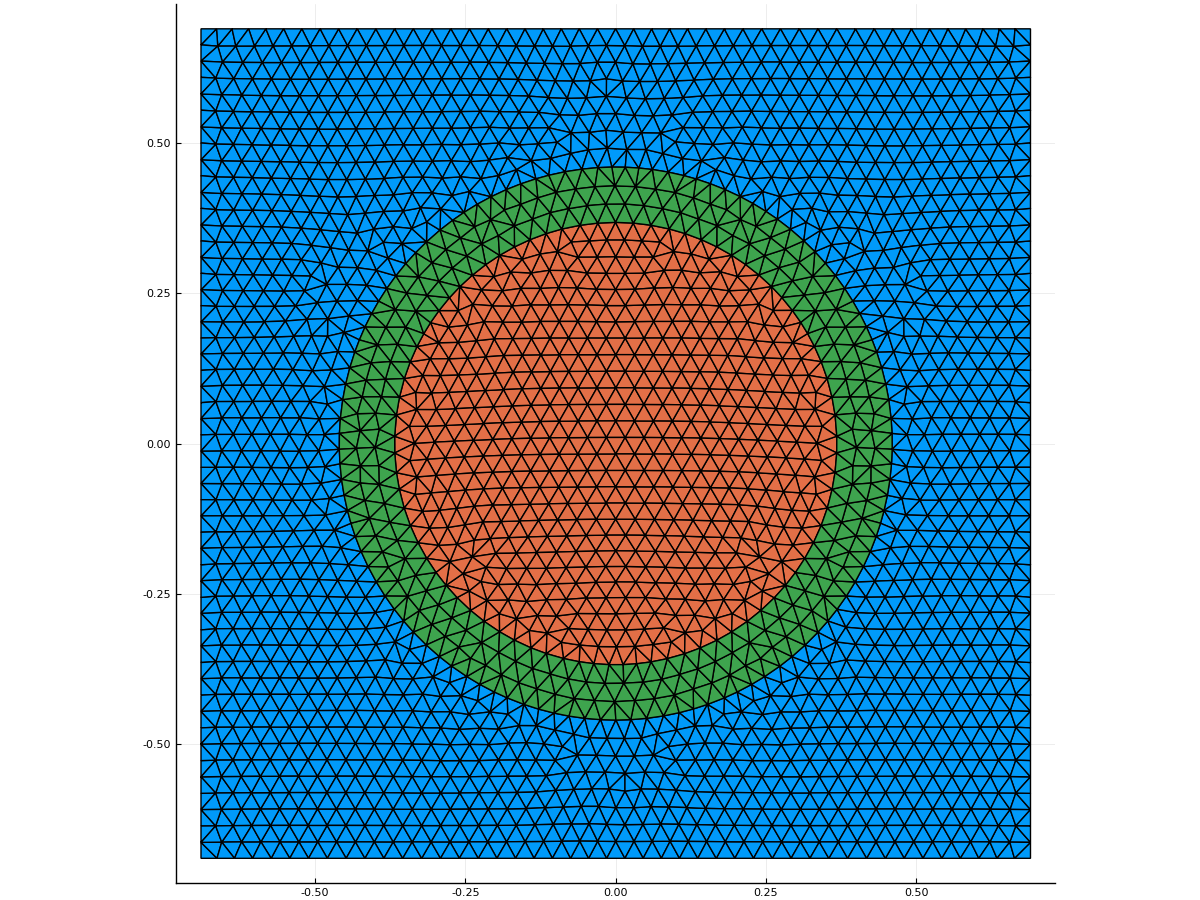

In [16]:
p = plot(; labels = :none);
simpplot!(p, geom.exteriorgrids);
simpplot!(p, geom.torigrids);
simpplot!(p, geom.interiorgrids);
p

In [7]:
exteriorgrids, torigrids, interiorgrids, outercircles, innercircles, bdry = geom;
ferritins = Vec{3,floattype(bdry)}[];

**Create domains**

In [17]:
# utype = ComplexF64; u0 = 1.0im;
# utype = Vec{2,Float64}; u0 = Vec{2}((0.0, 1.0));
utype = Vec{3,Float64}; u0 = Vec{3}((0.0, 0.0, 1.0));

In [18]:
myelinprob = MyelinProblem(btparams);

In [19]:
myelinsubdomains = createmyelindomains(
    vec(exteriorgrids), vec(torigrids), vec(interiorgrids),
    vec(outercircles), vec(innercircles), vec(ferritins),
    utype);

In [20]:
myelinprob, myelinsubdomains, myelindomains = createdomains(btparams,
    exteriorgrids, torigrids, interiorgrids,
    outercircles, innercircles, ferritins, utype);

    Assemble subdomains   

┌ Info: Assembling MyelinDomain from subdomains
└ @ MWFUtils C:\Users\Jonathan\Documents\MATLAB\BlochTorreyExperiments-master\MyelinWaterTools\MWFUtils\src\mwfutils.jl:385


  2.323064 seconds (3.81 M allocations: 178.754 MiB, 4.99% gc time)
    Factorize subdomains    0.194782 seconds (129.37 k allocations: 9.889 MiB, 6.38% gc time)
    Assemble combined       1.037155 seconds (1.38 M allocations: 85.843 MiB, 4.39% gc time)
    Factorize combined      0.011306 seconds (2.87 k allocations: 3.321 MiB)


**Solve Bloch-Torrey equation**

In [22]:
# Solve Bloch-Torrey equation
sols = solveblochtorrey(myelinprob, myelindomains;
    u0 = u0, flipangle = π,
    TE = 10e-3, TR = 1000e-3, nTE = 8, nTR = 1);

┌ Info: Solving MyelinProblem
└ @ MWFUtils C:\Users\Jonathan\Documents\MATLAB\BlochTorreyExperiments-master\MyelinWaterTools\MWFUtils\src\mwfutils.jl:525


180.0 degree pulse at t = 5.0 ms
180.0 degree pulse at t = 15.0 ms
180.0 degree pulse at t = 25.0 ms
180.0 degree pulse at t = 35.0 ms
180.0 degree pulse at t = 45.0 ms
180.0 degree pulse at t = 55.0 ms
180.0 degree pulse at t = 65.0 ms
180.0 degree pulse at t = 75.0 ms
  2.388629 seconds (509.39 k allocations: 955.251 MiB, 14.35% gc time)


In [46]:
sols_vec3 = deepcopy(sols);

In [38]:
sols_vec2 = deepcopy(sols);

In [30]:
sols_cplx = deepcopy(sols);

In [54]:
totrans(sols, utype) = reduce(vcat, transverse.(reinterpret(utype, u)) for u in sols[1].u)
@show totrans(sols_cplx, ComplexF64) ≈ totrans(sols_vec2, Vec{2,Float64});
@show totrans(sols_cplx, ComplexF64) ≈ totrans(sols_vec3, Vec{3,Float64});

totrans(sols_cplx, ComplexF64) ≈ totrans(sols_vec2, Vec{2, Float64}) = true
totrans(sols_cplx, ComplexF64) ≈ totrans(sols_vec3, Vec{3, Float64}) = true


# Testing

In [25]:
@show Revise.revision_queue; revise()

Revise.revision_queue = Set(Tuple{Revise.PkgData,String}[])


In [27]:
# utype = ComplexF64; u0 = 1.0 + 1.0im
# utype = Vec2d; u0 = ones(utype)
utype = Vec3d; u0 = ones(utype)
grid = generate_grid(Triangle, (3,3));
domain = ParabolicDomain(grid, utype);
u = interpolate(x->u0, domain);
S = integrate(u, domain)

2-element Tensor{1,2,Float64,2}:
 3.9999999999999614
 3.9999999999999614

In [220]:
# doassemble!(myelinsubdomains[1], myelinprob);
# M = getmass(myelinsubdomains[1]);
# @show M[1:3:end, 1:3:end] |> isposdef;
# @show M[2:3:end, 2:3:end] |> isposdef;
# @show M[3:3:end, 3:3:end] |> isposdef;
# @show M[1:3:end, 1:3:end] ≈ M[2:3:end, 2:3:end];
# @show M[1:3:end, 1:3:end] ≈ M[3:3:end, 3:3:end];
# @show maximum(abs, M[1:3:end, 2:3:end]) ≈ 0;
# @show maximum(abs, M[1:3:end, 3:3:end]) ≈ 0;
# @show maximum(abs, M[2:3:end, 1:3:end]) ≈ 0;
# @show maximum(abs, M[2:3:end, 3:3:end]) ≈ 0;
# @show maximum(abs, M[3:3:end, 1:3:end]) ≈ 0;
# @show maximum(abs, M[3:3:end, 2:3:end]) ≈ 0;